In [1]:
%matplotlib inline
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.signal import lombscargle
from itertools import cycle
import os
import time

In [2]:
datafolder='FirstSessionWithDAF_Nov10th'
npzfile_list = sorted([os.path.join(datafolder,x) for x in os.listdir(datafolder) if x.endswith('.npz')])

In [3]:
cl = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:brown', 'tab:purple', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:grey']
colorsdict = {'rectified_actuation': cl[0], 'vehicle_speed':cl[1], 'des_speed':cl[2], 
              'kp_term':cl[3], 'kd_term':cl[4], 'ki_term': cl[5], 'vehicle_displacement': cl[8],
              'pid_actuation':cl[6], 'speed_err':cl[7], 'accpos':cl[8], 'brakepos':cl[9]}
namesdict = {'rectified_actuation': 'Rectified Actuation', 'brakepos': 'Brake', 'kp_term': 'Proportional Term',
             'kd_term': 'Derivative Term', 'ki_term': 'Integral Term', 'vehicle_displacement': 'Vehicle displacement',
             'pid_actuation': 'PID Actuation', 'speed_err':'Speed Error', 'des_speed': 'Desired Speed'}
trial_info =[['1573414430.npz', (4.0, 10.0)],
             ['1573414625.npz', (2.0, 8.0)],
             ['1573414702.npz', (3.0, 15.0)],
             ['1573414925.npz', (4.0, 14.0)],
             ['1573415108.npz', (2.0, 13.0)],
             ['1573415175.npz', (7.0, 13.0)],
             ['1573415475.npz', (9.0, 16.0)],
             ['1573415507.npz', (2.0, 10.0)],
             ['1573415592.npz', (0.0, 8.0)],
             ['1573415663.npz', (0.0, 10.0)],
             ['1573415716.npz', (0.0, 10.0)],
             ['1573416028.npz', (0.0, 10.0)],
             ['1573416144.npz', (0.0, 10.0)],
             ['1573416255.npz', (0.0, 12.0)],
             ['1573416291.npz', (0.0, 10.0)],
             ['1573416424.npz', (0.0, 10.0)],
             ['1573416501.npz', (0.0, 10.0)],
             ['1573416602.npz', (0.0, 6.0)],
             ['1573416718.npz', (0.0, 10.0)],
             ['1573416824.npz', (0.0, 10.0)],
             ['1573416876.npz', (0.0, 10.0)]]

In [28]:
def tf_plotter(data, sig_groupping, time_range, plot_fft = True, max_freq = 5, fig_width=20, fig_height_per_row=3):
    # Colors
    cl_cycle = cycle(cl)
    for key in data.keys():
        if key not in colorsdict:
            colorsdict[key] = next(cl_cycle)
            
    # Getting rid of unknown signals
    checked_sig_groupping = []
    for sig_list in sig_groupping:
        checked_sig_list = []
        for signame in sig_list:
            if signame in data:
                checked_sig_list.append(signame)
        if len(checked_sig_list):
            checked_sig_groupping.append(checked_sig_list)
    sig_groupping = checked_sig_groupping

    # Time
    t = data['time']
    exp_time = t.min()
    datetimeobj = datetime.fromtimestamp(exp_time)
    date_str = datetimeobj.strftime("%A    %B %d, %Y     %H:%M")
    t = t - exp_time

    st_idx = np.argmax(t>=time_range[0])
    end_idx = np.argmax(t>=min(time_range[1], t.max()))

    t=t[st_idx: end_idx]
    #t = t - t.min()
    
    if 'sim_time' in data:
        t_sim = data['sim_time']
        t_sim = t_sim - exp_time
        st_idx_sim = np.argmax(t_sim>=time_range[0])
        end_idx_sim = np.argmax(t_sim>=min(time_range[1], t_sim.max()))
        t_sim=t_sim[st_idx_sim: end_idx_sim]
        #t_sim = t_sim - t_sim.min()
    
    dtmin = np.diff(t).min()
    duration = t.ptp()

    max_freq = max_freq or t.size/duration
    min_freq = 1/duration
    freqs = np.linspace(min_freq, max_freq, 200.)

    n_rows = len(sig_groupping)
    n_cols = 2 if plot_fft else 1

    fig_width_per_col = fig_width / n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * fig_width_per_col, n_rows * fig_height_per_row), sharex=False)#'col')
    #fig.set_dpi(600)
    if n_rows == 1:
        axes = [axes]
    if n_cols == 1:
        axes = [[ax_] for ax_ in axes]

    suptitle = f'          {date_str}      Kp = %.3g,     Kd= %.3g,      Ki=%.3g ' %(data['kp'][0], data['kd'][0], data['ki'][0])
    axes[0][0].set_title('Time domain' + suptitle)
    if plot_fft:
        axes[0][1].set_title('Frequency domain')
    i_axis = -1

    for siglist in sig_groupping:
        i_axis += 1
        is_last = (i_axis == n_rows-1)
        siglist_withsim = siglist + ['sim_'+x_ for x_ in siglist if 'sim_'+x_ in data]
        for in_signame in siglist_withsim:
            is_sim = in_signame.startswith('sim_')
            signame = in_signame[4:] if is_sim else in_signame
            linetype = 'k--' if is_sim  else 'k-'
            t_app = t_sim if is_sim else t
            ax = axes[i_axis][0]
            if is_sim:
                y = data[in_signame][st_idx_sim: end_idx_sim]
            else:
                y = data[in_signame][st_idx: end_idx]
            ax.plot(t_app, y, linetype, linewidth=1.5, color = colorsdict[signame], label='Sim ' + siglabel(signame) if is_sim else siglabel(signame))
            if not plot_fft:
                ax.legend(loc='upper right')
            if is_last:
                ax.set_xlabel('Time (s)')
            ax.grid()
            if plot_fft:
                ax = axes[i_axis][1]
                periodogram = lombscargle(t_app, y, freqs)
                kmax = periodogram.argmax()
                sig_ft = np.sqrt(4*periodogram/(5*t.size))
                ax.plot(freqs, sig_ft, linetype, linewidth=1.5, color = colorsdict[signame], label='Sim ' + siglabel(signame) if is_sim else siglabel(signame))
                #ax.axvline(freqs[kmax], color='r', alpha=0.25)
                ax.legend(loc='upper right')
                ax.grid()
                if is_last:
                    ax.set_xlabel('Frequency (Hz)')
                    
    return fig,axes

def scatter_plotter(data, xname='pid_actuation', yname = 'rectified_actuation'):
    x=data[xname]
    y=data[yname]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(x,y, s=3.)
    ax.set_xlabel(siglabel(xname))
    ax.set_ylabel(siglabel(yname))
    ax.set_title(f'{siglabel(yname)} vs {siglabel(xname)}')
    return ax, fig

def siglabel(signame):
    siglabel_ = ' '.join([x_ if i_ else x_.capitalize() for i_,x_ in enumerate(signame.split('_'))])
    siglabel_ = namesdict.get(signame, siglabel_)
    return siglabel_

In [29]:
class Sample2Signal:
    def __init__(self, t, samples):
        self.t = t
        self.samples = samples
        self.reset()
    
    def reset(self):
        self.index = 0
    
    def __call__(self, in_time):
        assert self.t[self.index] <= in_time
        assert self.index <= len(self.t) - 1 
        while self.index < len(self.t) - 1:
            if self.t[self.index] <= in_time and self.t[self.index+1] > in_time:
                break
            self.index += 1
        
        pre_index = self.index
        post_index = min(self.index+1, len(self.t)-1)
        t0 = self.t[pre_index]
        t1 = self.t[post_index]
        a = float(in_time - t0)
        b = float(t1 - in_time)
        if a+b==0:
            return self.samples[pre_index]
        out = b * self.samples[pre_index] + a * self.samples[post_index]
        return out / (a+b)

# Vehicle Parameters
class StraightLaneSimulator:
    def __init__(self, **kwargs):
        
        self.passenger_m = kwargs.get('passenger_m', 150.) #Kg
        self.M = kwargs.get('M', 907.) + self.passenger_m #Kg
        self.C_d = kwargs.get('C_d', 0.5)
        self.C_r = kwargs.get('C_r', 0.01)
        self.rho = kwargs.get('rho', 1.225)
        self.A = kwargs.get('A', 2.61)
        self.g = kwargs.get('g', 9.81)
        self.r = kwargs.get('r', 0.25)
        self.K_b = kwargs.get('K_b', 13.33)
        self.alpha = kwargs.get('alpha', 1.) # Used for brake modelling
        self.sensor_delay = kwargs.get('sensor_delay', 0.)
        self.sensor_zerohold = kwargs.get('sensor_zerohold', 0.)
        
        # The slope of the road
        self.Theta = kwargs.get('Theta', -.0 * np.pi / 180.)
        
        # The Integrator parameters (RK4)
        self.h = kwargs.get('h', 1e-3)
        
        # Computing Coefficients of DE
        self.C_v2 = self.C_d * self.rho * self.A / 2. # 0.7993125
        self.C_v = self.M * self.g * self.C_r # 88.97
        self.C = self.M * self.g * np.sin(self.Theta)
        
        self.sensor_zerohold_steps = max(1, int(self.sensor_zerohold / self.h))
        self.state = None
        
    def v_dot(self, v_, u_a, u_b):
        # v_ is the current speed in m/s
        # u_a is the acceleration pedal level (i.e. inside [0,1])
        # u_b is the braking pedal level (i.e. inside [0,1])
        T_a = 1000 * u_a * (1 - float(0.3<u_a<0))
        T_b = 1.5 * u_b * self.K_b * min(1.,  v_ / (self.r * self.alpha))
        T = T_a - T_b
        u = T / self.r
        return (u - self.C_v2 * (v_**2) - self.C_v * v_ - self.C) / self.M
    
    def rk4_step(self, curr_v, curr_u_a, curr_u_b, mid_u_a, mid_u_b, next_u_a, next_u_b):
        k1 = self.h * self.v_dot(curr_v        , curr_u_a,   curr_u_b)
        k2 = self.h * self.v_dot(curr_v + k1/2., mid_u_a ,   mid_u_b ) 
        k3 = self.h * self.v_dot(curr_v + k2/2., mid_u_a ,   mid_u_b ) 
        k4 = self.h * self.v_dot(curr_v + k3   , next_u_a,   next_u_b)
        next_v = curr_v + (k1 + 2*k2 + 2*k3 + k4) / 6.
        return next_v, k1/self.h
    
    def zero_hold_list(self, in_list_, num_steps):
        if num_steps == 1:
            return in_list_
        
        for i_ in range(len(in_list_)):
            if (i_ % num_steps) >= 1:
                in_list_[i_] = in_list_[i_-1]
        return in_list_
                
    
    def system(self, accsignal, brakesignal, init_v, time_range):
        init_t = time_range[0]
        duration = time_range[1] - time_range[0]
        N = int(duration / self.h)
        accsignal.reset()
        brakesignal.reset()
        
        sim_v = np.zeros(N)
        sim_vdot = np.zeros(N)
        sim_t = np.zeros(N)
        
        tn = init_t
        vn = init_v
        
        for n in range(N):
            sim_v[n] = vn
            sim_t[n] = tn
            curr_u_a, curr_u_b = accsignal(tn), brakesignal(tn)
            mid_u_a, mid_u_b = accsignal(tn+self.h/2), brakesignal(tn+self.h/2)
            next_u_a, next_u_b = accsignal(tn+self.h/2), brakesignal(tn+self.h/2)
            next_v, curr_vdot = self.rk4_step(vn, curr_u_a, curr_u_b, mid_u_a, mid_u_b, next_u_a, next_u_b)
            sim_vdot[n] = curr_vdot
            tn = tn + self.h
            vn = next_v
        
        out_t    = sim_t + self.sensor_delay
        out_v    = self.zero_hold_list(sim_v    , self.sensor_zerohold_steps)
        out_vdot = self.zero_hold_list(sim_vdot , self.sensor_zerohold_steps)
        return out_t, out_v, out_vdot
    
    def simulate(self, t_list, acc_list, brake_list, init_v, time_range):
        accsignal = Sample2Signal(t_list, acc_list)
        brakesignal = Sample2Signal(t_list, brake_list)
        return self.system(accsignal, brakesignal, init_v, time_range)
    
    def reset(self, init_v=0.):
        self.state = dict(v = init_v)
        self.delay_steps = int(self.sensor_delay / self.h)
        self.v_history = [init_v  for x_ in range(self.delay_steps)]
    
    def step(self, u_a, u_b):
        assert self.state is not None, 'Make sure you initialize the state by calling reset'
        last_v = self.state['v']
        next_v, curr_vdot = self.rk4_step(last_v, u_a, u_b, u_a, u_b, u_a, u_b)
        self.state['v'] = next_v
        self.v_history.append(next_v)
        if self.sensor_zerohold == 0:
            idx_ = len(self.v_history)-self.delay_steps
        else:
            idx_ = ((len(self.v_history)-self.delay_steps) // self.sensor_zerohold_steps) * self.sensor_zerohold_steps
        return self.v_history[idx_], idx_
    
def integ_sig(t_list, sig_list):
    integ_ = np.cumsum(np.diff(t_list) * sig_list[:-1])
    return np.append(integ_, integ_[-1])

def load_and_process(trial_number):
    npz_path = datafolder + '/' + trial_info[trial_number][0]
    time_range = trial_info[trial_number][1]
    data = np.load(npz_path)
    data = {k_:data[k_] for k_ in data.files}
    sim_time_range = (time_range[0] + data['time'][0], time_range[1] + data['time'][0])
    data['sim_time'] , data['sim_vehicle_speed'] , sim_vdot = simulator.simulate(data['time'], data['accpos'], data['brakepos'], init_v = 0., time_range = sim_time_range)
    data['vehicle_displacement'] = integ_sig(data['time'], data['vehicle_speed'])
    data['sim_vehicle_displacement'] = integ_sig(data['sim_time'], data['sim_vehicle_speed'])
    return data, time_range

In [31]:
sig_groupping = [['vehicle_speed'], ['pid_actuation', 'rectified_actuation'], ['kp_term', 'kd_term', 'ki_term'], 
                 ['speed_err'], ['des_speed'], ['brakepos'], ['vehicle_displacement']]

# Description

### Credit to Matthew Benton Salfer-Hobbs for physical modelling
https://repository.lib.fit.edu/bitstream/handle/11141/2896/SALFER-HOBBS-THESIS-2019.pdf?sequence=1&isAllowed=y

## A simple model for the vehicle is as follows:
$$\huge M \frac{dv}{dt} + \frac{1}{2} C_d\rho A v^2 + M g C_r v + M g \sin(\Theta) = \frac{T}{r}$$

$$\Large T = 1000 \cdot u_a - 1.5 \cdot u_b \cdot K_b \min(1, \frac{v}{r\alpha})$$

## For our GEM, the following parameters are popular:
$$\Large M = 907 \quad Kg$$

$$\Large C_d = .5 $$

$$\Large C_r = .01$$

$$\Large \rho = 1.225 \quad Kg/m^3$$

$$\Large A = 2.61 \quad m^2 $$

$$\Large g = 9.81 \quad m/s^2 $$

$$\Large r = 0.25 \quad m $$

$$\Large K_b = 13.33 \quad N\cdot m/bar $$

# How to use this Differential Equation as a model?

### 1) Write 
$$\large \frac{dv}{dt} = f(t, v(t))$$
### 2) Use a DE integrator to integrate over $f$. 
   
#### We used 4th order Runge-Kutta known as RK4.

# Howerver this is not good enough:

### 1) This model assumes no slipping. (High bay is THE technical definition of slipping).

### 2) The speed sensor is slow (~30 Hz refresh rate)

### 3) The following data might suggest that the speed sensor has a huge delay (~0.35 sec)


In [30]:
simulator = StraightLaneSimulator(C_r = 0.4, sensor_delay = 0.35, sensor_zerohold=.032)

# Trials

(<matplotlib.axes._subplots.AxesSubplot at 0x2b93dfc64cf8>,
 <Figure size 720x720 with 1 Axes>)

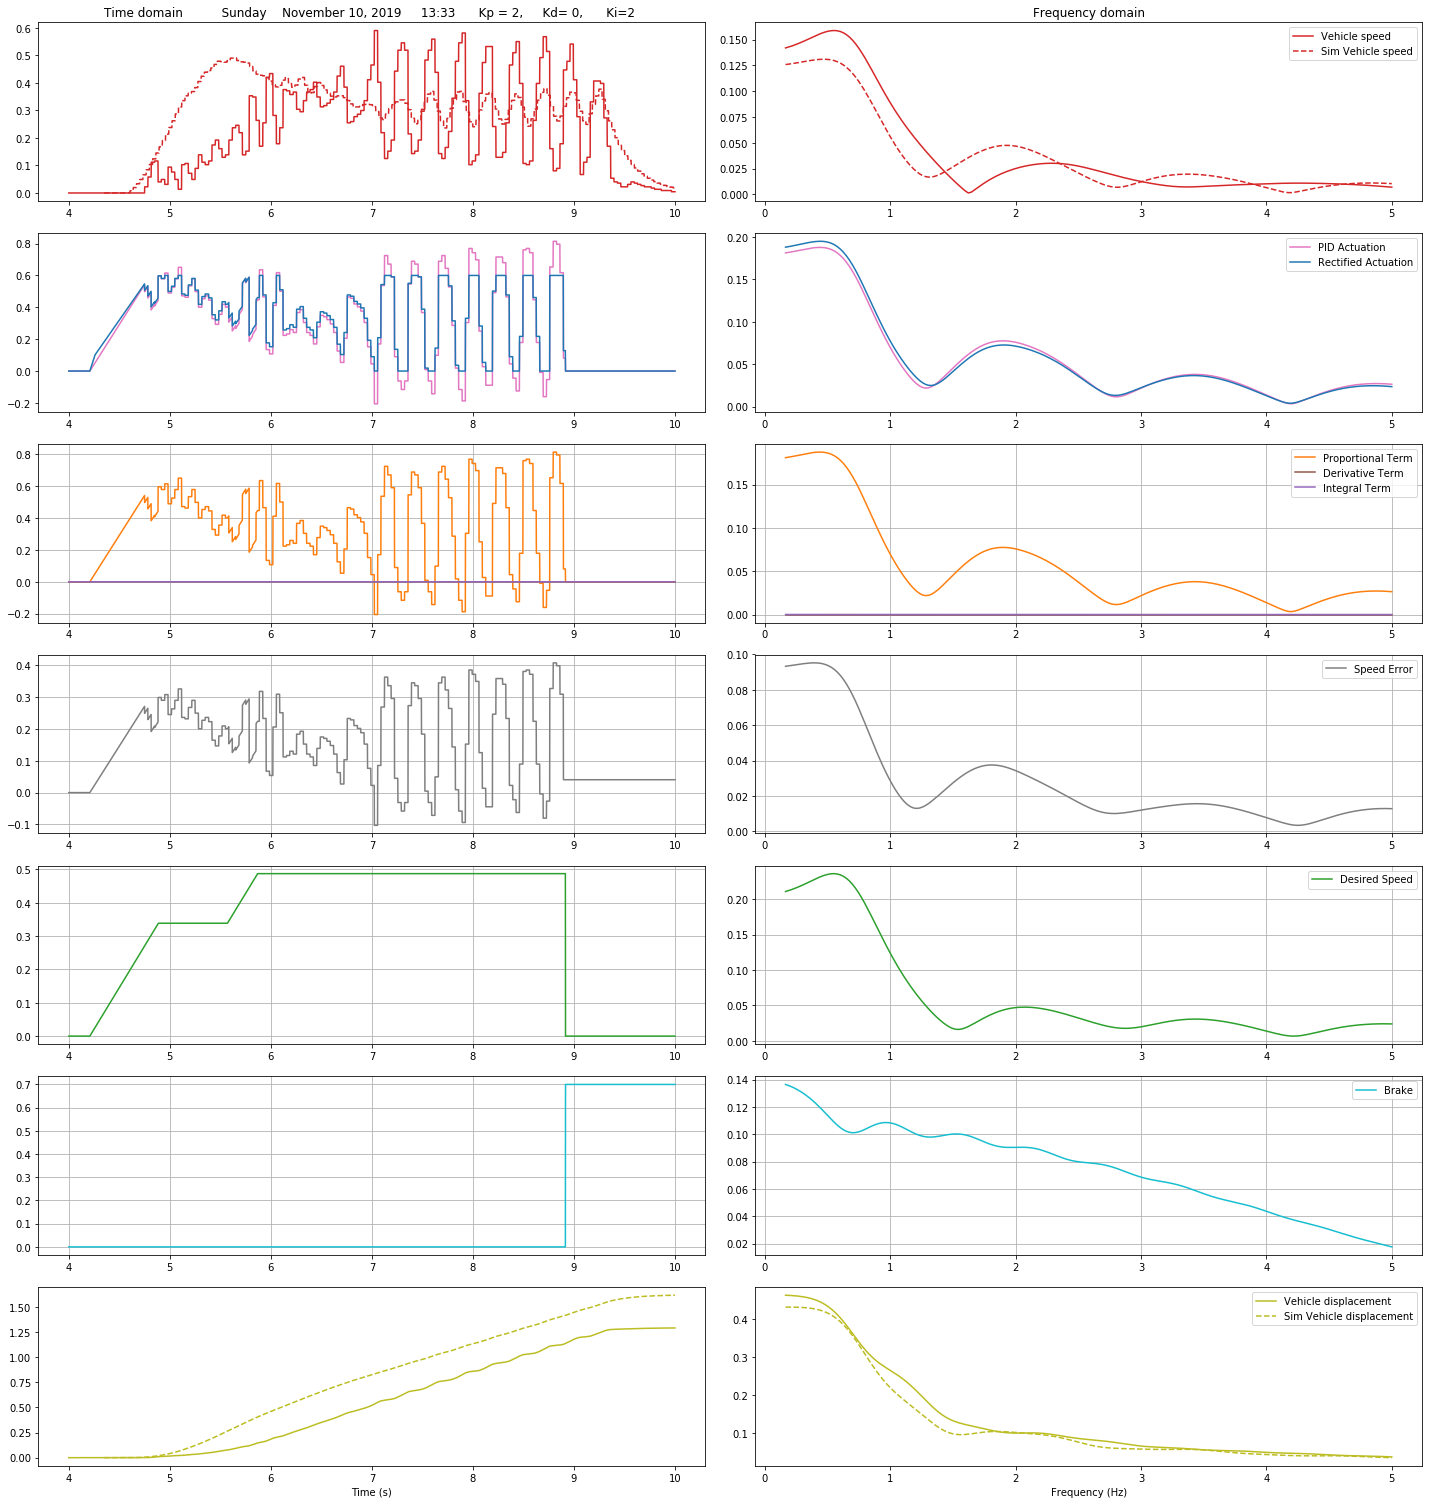

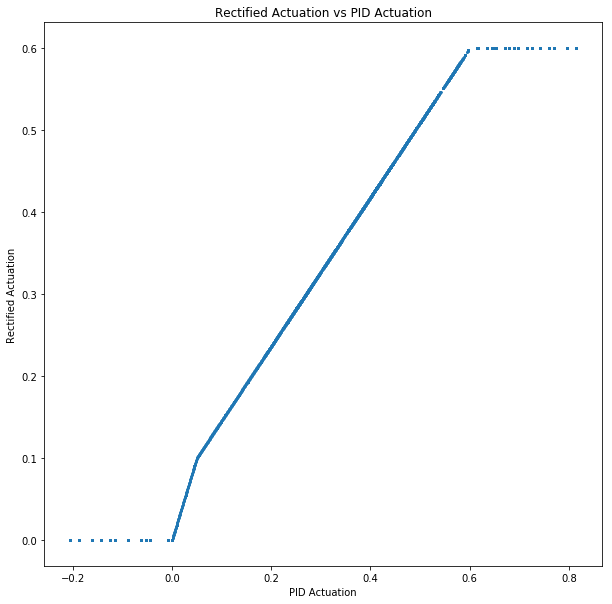

In [33]:
trial_number = 0

data, time_range = load_and_process(trial_number)
fig, axes = tf_plotter(data, sig_groupping=sig_groupping, time_range = time_range, fig_height_per_row=3, fig_width=20, plot_fft=True, max_freq = 5)
fig.set_tight_layout(True)
scatter_plotter(data, xname='pid_actuation', yname = 'rectified_actuation')

# Tunning PID in simulation

In [34]:
class PID:
    def __init__(self, kp, kd, ki, ctrl2sensor_freq_ratio = 1):
        self.kp = kp
        self.kd = kd
        self.ki = ki
        self.ctrl2sensor_freq_ratio = ctrl2sensor_freq_ratio
        self.reset()

    def reset(self):
        self.last_e = None
        self.last_t = None
        self.integ_e = 0.
        self.last_timestamp = -1
        self.last_err_dot = None

    def __call__(self, err, dt=None, timestamp=None):
        now_t = time.time()
        self.last_t = self.last_t or now_t
        self.last_e = self.last_e or err
        mydt = dt or (now_t - self.last_t)
        mydt = max(mydt, 1e-6)
        if timestamp is None:
            err_dot = (err - self.last_e) / mydt
        else:
            # Since the sensor update frequency is smaller than the control frequency, 
            # error derivative should have a zeor-order hold filter applied to it.
            if timestamp == self.last_timestamp:
                err_dot = self.last_err_dot
            else:
                err_dot = (err - self.last_e) / mydt
                self.last_err_dot = err_dot
                self.last_timestamp = timestamp
        self.integ_e = self.integ_e + err * mydt
        kp_term = self.kp * err
        kd_term = self.kd * err_dot / self.ctrl2sensor_freq_ratio 
        ki_term = self.ki * self.integ_e
        actuation = kp_term + kd_term + ki_term
        self.last_t = now_t
        self.last_e = err
        return actuation, kp_term, kd_term, ki_term
    
class Rectifier:
    def __init__(self, pts):
        self.pts = list(sorted(pts, key= lambda x_: x_[0]))
        assert len(pts) > 0
        self.pts = [(-1e20, self.pts[0][1])] + self.pts + [(1e20, self.pts[-1][1])]

    def __call__(self, f):
        for i in range(len(self.pts)-1):
            pt1_x = self.pts[i][0]
            pt1_y = self.pts[i][1]
            pt2_x = self.pts[i+1][0]
            pt2_y = self.pts[i+1][1]

            if (f >= pt1_x) and (f < pt2_x):
                h = pt1_y + (pt2_y - pt1_y) * float(f-pt1_x) / float(pt2_x - pt1_x)
                return h

class DataCollector:
    def __init__(self, enable=True):
        self.data = dict()
        self.enable = enable

    def push(self, name, val):
        if self.enable:
            if name in self.data:
                self.data[name].append(val)
            else:
                self.data[name] = list()

In [56]:
def sim_traj(v_cmd, pid_speed, rectifier, simulator, h = 1e-3, init_v = 0., duration = 15):
    data_collector = DataCollector()
    t_init = time.time()
    tn = t_init
    N = int(duration//h)
    vehicle_speed = init_v
    simulator.reset(init_v = init_v)
    time_stamp = tn

    for n in range(N):
        des_speed = v_cmd(tn-t_init)
        speed_err = des_speed - vehicle_speed
        pid_actuation, kp_term, kd_term, ki_term = pid_speed(speed_err, h, time_stamp)
        rectified_actuation = rectifier(pid_actuation)
        accpos= np.clip(rectified_actuation, 0., 1.)
        brakepos= np.clip(-rectified_actuation, 0., 1.)

        data_collector.push('time', tn)
        data_collector.push('des_speed', des_speed)
        data_collector.push('vehicle_speed', vehicle_speed)
        data_collector.push('speed_err', speed_err)
        data_collector.push('pid_actuation', pid_actuation)
        data_collector.push('rectified_actuation', rectified_actuation)
        data_collector.push('accpos', accpos)
        data_collector.push('brakepos', brakepos)
        data_collector.push('kp', pid_speed.kp)
        data_collector.push('kd', pid_speed.kd)
        data_collector.push('ki', pid_speed.ki)
        data_collector.push('kp_term', kp_term)
        data_collector.push('kd_term', kd_term)
        data_collector.push('ki_term', ki_term)

        vehicle_speed, time_stamp = simulator.step(accpos, brakepos)
        tn = tn + h
    for key in data_collector.data:
        data_collector.data[key] = np.array(data_collector.data[key])
    return data_collector


## Manual Tunning Recommendation

According to wikipedia:
   
   The (proportional) gain, $K_{p}$ is then increased (from zero) until it reaches the ultimate gain $K_{u}$, at which the output of the control loop has stable and consistent oscillations. $K_{u}$ and the oscillation period $T_{u}$ are used to set the P, I, and D gains depending on the type of controller used...

Listening to wikipedia for the following configuration, it seems that $K_u=2$ and $T_u = 1$.

(<matplotlib.axes._subplots.AxesSubplot at 0x2b93df44b748>,
 <Figure size 720x720 with 1 Axes>)

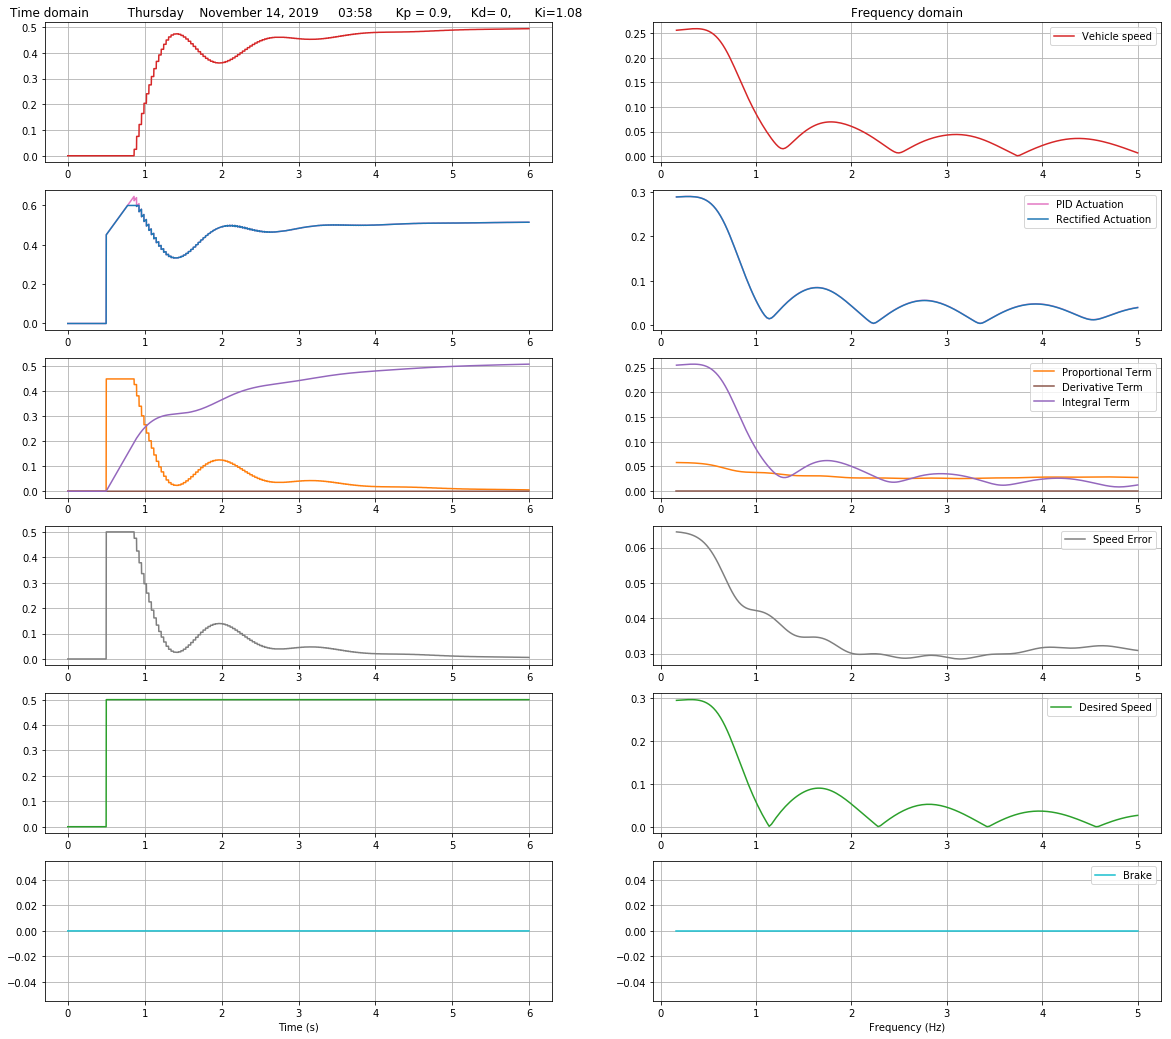

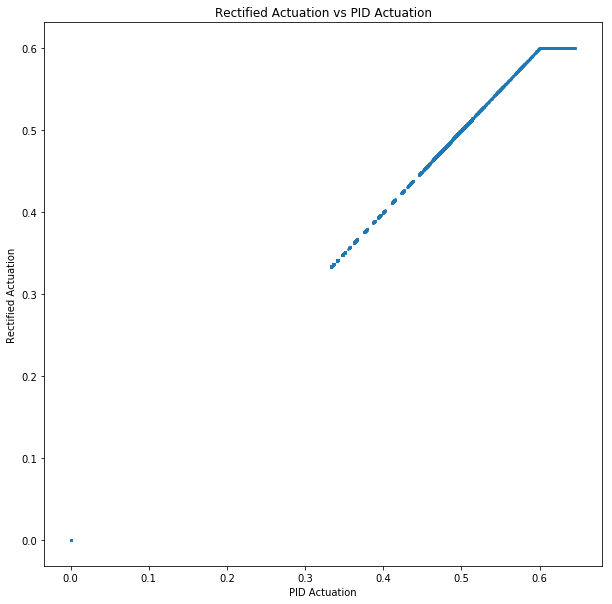

In [82]:
simulator = StraightLaneSimulator(C_r = .4, sensor_delay = 0.35, sensor_zerohold=.032)
v_cmd = lambda t_: 0.5 if t_>0.5 else 0.
K_u = 2.
T_u = 1.
pid_speed = PID(kp=0.45*K_u, kd=0., ki=0.54*K_u/T_u, 
                ctrl2sensor_freq_ratio = 0.030/0.001)
rectifier = Rectifier(pts = [( -1. ,   -1.   ),
                             (  0. ,    0.   ),
                             ( 0.6 ,    0.6  ),
                            ])
data_collector = sim_traj(v_cmd, pid_speed, rectifier, simulator, h=1e-3, init_v = 0., duration = 6)
fig, axes = tf_plotter(data_collector.data, sig_groupping=sig_groupping,  time_range = (0., 6.))
scatter_plotter(data_collector.data, xname='pid_actuation', yname = 'rectified_actuation')